Ahh, probabilistic graphical models.
I think it's pretty safe to assert that this class of models is underappreciated by our data science community.
Today we'll look at a particular PGM called a *causal bayesian network*,
and we'll use it to answer some questions about an organization's website traffic.
We'll implement our causal bayesian network with a python library called `pgmpy`, so this post is both an introduction to causal graphical models and a `pgmpy` tutorial.

## Causal Graphical Models

So, what the heck is a causal graphical model?
Well it's a nifty intuitive way to represent our assumptions about the causal relationships among variables using a *directed acyclic graph* or DAG.
The nodes of the DAG represent random variables and the arrows between nodes indicate that one variable causes another. 
In the below  causal DAG, Z and U cause X and U causes Y.

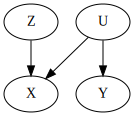

In [ ]:
#| code-fold: true
#| fig-alt: causal DAG with z and u causing x and u causing y

import graphviz as gr 

g = gr.Digraph()
g.edge("Z", "X")
g.edge("U", "X")
g.edge("U", "Y")
g

One of the magical things about a causal DAG is that it has a probabilistic interpretation;
namely it implies a certain factorization of the joint distribution.
In this factorization, each random variable will get its own factor, where nodes without parents take  their marginal distribution $P(\cdot)$, and nodes with parents take a conditional distribution given their parents $P(\cdot|parents)$.
In the above DAG the joint distribution factors as:

$$ P(U,X,Y,Z) = P(Z) P(U) P(X|U,Z) P(Y|U) $$

Why is that useful? Well the modularity of the factorized right hand side makes it easier to work with.
Imagine trying to model the system; it's more tractable to model each of those factors individually rather than trying to model the entire joint distribution all at once.

A causal DAG also implies certain conditional independence relationships among the random variables in the system which are critical for doing valid causal inference.
Check out [this chapter on causal graphical models](https://matheusfacure.github.io/python-causality-handbook/04-Graphical-Causal-Models.html) for the details.

## Analyzing Website Traffic

Let's suppose you're a data scientist at some kind of wholesome non-profit  organization that wants to better understand its website traffic and subscriptions to its mailing list.
You have some log data with one row per user visit to your website having the following variables:

* **referrer** - how the user got to your website, either a link on a social media site or a link from search engine results
* **locale** - the user's ip address region, either east or west
* **entrypoint** - where the user landed on your website, either on one of your blog posts or on one of your videos
* **search** - whether or not the user used your site search bar
* **subscribe** - whether or not the user subscribed to your mailing list

The data looks like this.

In [81]:
#| output: false
#| code-fold: true
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphviz as gr
import networkx as nx
from pgmpy.factors.discrete import TabularCPD
from pgmpy.models import BayesianNetwork

graph = [
    ('referrer', 'entrypoint'),
    ('locale', 'entrypoint'),
    ('entrypoint', 'search'),
    ('entrypoint', 'subscribe'),
    ('search', 'subscribe')
]

# g = gr.Digraph()
# g.edges(list(graph))
# g

cpd_r = TabularCPD(variable='referrer', variable_card=2,
                  values=[[0.3], [0.7]], state_names={'referrer': ['social-media', 'search-engine']})
cpd_l = TabularCPD(variable='locale', variable_card=2,
                  values=[[0.5], [0.5]], state_names={'locale': ['east', 'west']})
cpd_e = TabularCPD(variable='entrypoint', variable_card=2,
                  values=[[0.25, 0.3, 0.82, 0.8],
                          [0.75, 0.7, 0.18, 0.2]],
                  evidence=['referrer', 'locale'],
                  evidence_card=[2, 2],
                  state_names={'entrypoint': ['blog', 'video'], 'referrer': ['social-media', 'search-engine'], 'locale': ['east', 'west']})
cpd_se = TabularCPD(variable='search', variable_card=2,
                  values=[[0.4, 0.1],
                          [0.6, 0.9]],
                  evidence=['entrypoint'],
                  evidence_card=[2],
                  state_names={'entrypoint': ['blog', 'video'], 'search': [True, False]})
cpd_su = TabularCPD(variable='subscribe', variable_card=2,
                  values=[[0.15, 0.05, 0.03, 0.01],
                          [0.85, 0.95, 0.97, 0.99]],
                  evidence=['entrypoint', 'search'],
                  evidence_card=[2, 2],
                  state_names={'entrypoint': ['blog', 'video'], 'search': [True, False], 'subscribe': [True, False]})
# print(cpd_r)
# print(cpd_l)
# print(cpd_e)
# print(cpd_se)
# print(cpd_su)

model = BayesianNetwork(graph)
model.add_cpds(cpd_r, cpd_l, cpd_e, cpd_se, cpd_su)

assert model.check_model()

visit_df = model.simulate(n_samples=5000, seed=42)


  0%|          | 0/5 [00:00<?, ?it/s]

In [82]:
visit_df.head()

,referrer,search,subscribe,locale,entrypoint
0,search-engine,False,False,east,blog
1,search-engine,True,False,east,blog
2,search-engine,False,True,west,blog
3,search-engine,True,False,east,blog
4,social-media,True,False,west,blog


## Causal DAG

The first step in building a causal graphical model is to represent the what-causes-what relationships between variables using a causal DAG.
There are (somewhat fraught) ways to attempt to learn these relationships from data, but we'll adopt a modeling philosophy whereby we make explicit assumptions about the causal relationships in the system based on common sense and domain knowledge.
Here's a potential DAG for the website traffic data.


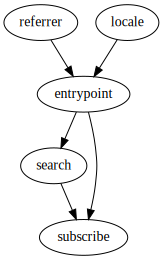

In [91]:
import graphviz as gr 

graph = [
    ('referrer', 'entrypoint'),
    ('locale', 'entrypoint'),
    ('entrypoint', 'search'),
    ('entrypoint', 'subscribe'),
    ('search', 'subscribe')
]

g = gr.Digraph()
g.edges(graph)
g

This DAG is saying that some combination of a user's location (locale) and whether they're coming from a social media site or a search engine (referrer) causes what kind of page they land on in our website (entrypoint).
It then says that the website entrypoint causes whether or not they interact with our search bar (search),
and both search bar interaction and entrypoint cause whether the user subscribes to the mailing list (subscribe).
Maybe you find this DAG reasonable, or maybe you don't.
Either way, that's good, because the DAG clearly communicates our modeling assumptions about what-causes-what, and it gives our peers a chance to challenge and hopefully refine our

In addition to communicating our assumptions, the causal DAG also has some useful implications on how we model the system and answer questions about it.
In particular, the DAG implies certain conditional independence relationships among the variables, which in turn implies a particular factorization of their joint probability distribution.
We won't go into details here, but you can read about the conditional independence relationships implied by a causal DAG [in any decent reference on causal graphical models](https://matheusfacure.github.io/python-causality-handbook/04-Graphical-Causal-Models.html).
As for the factorization of the joint probability distribution, our DAG implies the following :

```
P(ref, loc, ent, sea, sub) = P(ref) 
                             * P(loc) 
                             * P(ent | ref, loc) 
                             * P(sea | ent) 
                             * P(sub | ent, sea)
```

You can probably see the pattern.
Each variable gets its own factor.
Variables with no parents in the DAG take their marginal distribution.
Variables with parents in the DAG take their conditional distribution given their parents.

## Bayesian Network

So far we have a causal DAG that expresses our assumptions about what causes what in our website visit system.
There are lots of different causal graphical models which are compatible with our DAG and which we could use to model the system.
Here we'll hone in on the simplest and apparently most classical causal graphical model, the [*discrete bayesian network*](https://en.wikipedia.org/wiki/Bayesian_network).
In a discrete bayes net, all random variables have [categorical distributions](https://en.wikipedia.org/wiki/Categorical_distribution), i.e. they take only a finite set of discrete values.
This is perfect for our website visit system, because each variable takes only two discrete values.

In [87]:
visit_df.apply(lambda x: len(np.unique(x)))

referrer      2
search        2
subscribe     2
locale        2
entrypoint    2
dtype: int64

The [`pgmpy`](https://pgmpy.org/) 
python library implements several probabilistic graphical models including discrete bayes nets.
We instantiate a bayes net model object with our DAG, and we fit it with our data.

In [93]:
from pgmpy.models import BayesianNetwork 

bn = BayesianNetwork(graph)
bn.fit(visit_df)

If you're used to doing supervised learning, you'll notice that we don't specify target and features in the call to the `fit` method; we just pass in a dataframe containing all the variables in our system.
You can think of training the bayes net as estimating the joint distribution of all the variables in the model.
We'll see that this is a far more flexible paradigm than supervised learning, allowing us to answer a much wider array of questions with the model.
Let's take a look at what we can do with a trained bayes net.

### Joint Distribution: Probability of a State

Since our bayes net is just a model of the joint distribution, let's start by querying the joint probability for some event, say a visit where the user is coming from social media in the east region, lands on a blog post, and neither uses search or subscribes to our mailing list.


In [97]:
# joint probability
bn.get_state_probability({
    'referrer': 'social-media',
    'locale': 'east',
    'entrypoint': 'blog',
    'search': False,
    'subscribe': False
})

0.023051688832212255

### Inference: Conditional Probability of This Given That

Most of our probabilistic questions fall into this category of inference.
The general pattern is "what is the conditional probability distribution of these variables given specific values of those variables?"

In [111]:
from pgmpy.inference import VariableElimination

inference = VariableElimination(bn)

In [114]:
evidence = {'search': False, 'locale': 'east'}
print(inference.query(['subscribe'], evidence=evidence))

+------------------+------------------+
| subscribe        |   phi(subscribe) |
+==================+==================+
| subscribe(False) |           0.9754 |
+------------------+------------------+
| subscribe(True)  |           0.0246 |
+------------------+------------------+


In [118]:
X = pd.DataFrame(evidence, index=[0])
bn.predict_probability(X)

,subscribe_False,subscribe_True,referrer_search-engine,referrer_social-media,entrypoint_blog,entrypoint_video
0,0.975362,0.024638,0.648596,0.351404,0.552634,0.447366


## Interventions

In [130]:
[0 if _ % 2 == 0 else 1 for _ in range(10)]

[0, 1, 0, 1, 0, 1, 0, 1, 0, 1]

In [150]:
def do(model, interventions):
    new_model = model.copy()
    for var, state in interventions.items():
        states = model.get_cpds(var).state_names[var]
        cpd_var = TabularCPD(variable=var, variable_card=len(states),
                             values=[[1.] if s == state else [0.] for s in states], state_names={var: states})
        new_model.do(nodes=[var], inplace=True)
        new_model.add_cpds(cpd_var)
    return new_model

bn_do0 = do(bn, {'entrypoint': 'blog'})
bn_do1 = do(bn, {'entrypoint': 'video'})


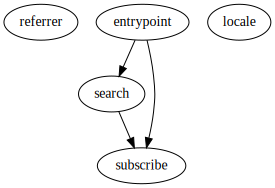

In [201]:
g = gr.Digraph() 
for node in bn_do0.nodes(): g.node(node)
g.edges(bn_do0.edges()) 
g

In [152]:
print(bn_do0.get_cpds('entrypoint'))

+-------------------+---+
| entrypoint(blog)  | 1 |
+-------------------+---+
| entrypoint(video) | 0 |
+-------------------+---+


In [179]:
VariableElimination(bn_do0).query(['subscribe']).values,\
VariableElimination(bn_do1).query(['subscribe']).values

(array([0.9201509, 0.0798491]), array([0.9884552, 0.0115448]))

In [174]:
do_inference = VariableElimination(bn.do(nodes=['entrypoint']))
do_inference.query(['subscribe'], evidence={'entrypoint': 'blog'}).values, \
do_inference.query(['subscribe'], evidence={'entrypoint': 'video'}).values

(array([0.9201509, 0.0798491]), array([0.9884552, 0.0115448]))

### ATE

In [183]:
p0 = do_inference.query(['subscribe'], evidence={'entrypoint': 'blog'}).values
p1 = do_inference.query(['subscribe'], evidence={'entrypoint': 'video'}).values
p1 - p0

array([ 0.0683043, -0.0683043])

### CATE

In [187]:
print('search=True')
p0 = do_inference.query(['subscribe'], evidence={'entrypoint': 'blog', 'search': True}).values
p1 = do_inference.query(['subscribe'], evidence={'entrypoint': 'video', 'search': True}).values
print(p1 - p0)

print('search=False')
p0 = do_inference.query(['subscribe'], evidence={'entrypoint': 'blog', 'search': False}).values
p1 = do_inference.query(['subscribe'], evidence={'entrypoint': 'video', 'search': False}).values
print(p1 - p0)

search=True
[ 0.09126735 -0.09126735]
search=False
[ 0.0333857 -0.0333857]


## 1.4 Estimating the Parameters: Conditional Probability Tables

Estimate the probabilities in the marginal mass functions using the dataset and MLE.

In [ ]:
model_mle = BayesianNetwork(graph)
model_mle.fit(data=df, estimator=None)
model_mle.get_cpds()
print(model_mle.get_cpds('O'))

+---------+----------------------+----------------------+
| E       | E(high)              | E(uni)               |
+---------+----------------------+----------------------+
| O(emp)  | 0.9827586206896551   | 0.9761904761904762   |
+---------+----------------------+----------------------+
| O(self) | 0.017241379310344827 | 0.023809523809523808 |
+---------+----------------------+----------------------+


The MLE estimates are the same as what you get by just directly computing frequencies from the dataset.

In [ ]:
pd.crosstab(df['O'], df['E'], normalize='columns')

E,high,uni
O,,
emp,0.982759,0.97619
self,0.017241,0.02381


### Bayesian Estimation

Including a prior makes estimation more robust, avoiding issues with sparse data and zero or one estimated probabilities.
They recommend using a prior pseudo count around 10 or 15.

In [ ]:
from pgmpy.estimators import BayesianEstimator

model = BayesianNetwork(graph)
model.fit(data=df, estimator=BayesianEstimator,
          prior_type='dirichlet', pseudo_counts=10)
print(model.get_cpds('O'))


+---------+---------------------+---------------------+
| E       | E(high)             | E(uni)              |
+---------+---------------------+---------------------+
| O(emp)  | 0.9516129032258065  | 0.9347826086956522  |
+---------+---------------------+---------------------+
| O(self) | 0.04838709677419355 | 0.06521739130434782 |
+---------+---------------------+---------------------+


## 1.5 Learning the DAG structure: tests and scores

### 1.5.1 Conditional independence tests

In [ ]:
from pgmpy.estimators.CITests import chi_square

result = chi_square(X='T', Y='E', Z=['O', 'R'], data=df, boolean=False)
print(f'test-stat: {result[0]}\ndof: {result[2]}\np-value: {result[1]}')

test-stat: 7.015260050091365
dof: 6
p-value: 0.31943826436448475


In [ ]:
from pgmpy.estimators.CITests import g_sq

result = g_sq(X='T', Y='E', Z=['O', 'R'], data=df, boolean=False)
print(f'test-stat: {result[0]}\ndof: {result[2]}\np-value: {result[1]}')

test-stat: 8.791068947346504
dof: 6
p-value: 0.1856736363240663


In [ ]:
result = chi_square(X='O', Y='T', Z=['R'], data=df, boolean=False)
print(f'test-stat: {result[0]}\ndof: {result[2]}\np-value: {result[1]}')

test-stat: 4.4362382497773165
dof: 4
p-value: 0.35017506679699717


/usr/local/lib/python3.10/dist-packages/pgmpy/estimators/CITests.py:547: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for z_state, df in data.groupby(Z):


### Learning the DAG structure from data **bold text** with PC algorithm

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pgmpy/estimators/CITests.py:547: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for z_state, df in data.groupby(Z):
/usr/local/lib/python3.10/dist-packages/pgmpy/estimators/CITests.py:547: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for z_state, df in data.groupby(Z):
/usr/local/lib/python3.10/dist-packages/pgmpy/estimators/CITests.py:547: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for z_state, df in data.groupby(Z):
/usr/local

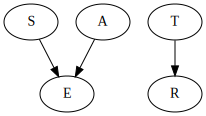

In [ ]:
from pgmpy.estimators import PC

pc = PC(data=df)
estimated_dag = pc.estimate()
g = gr.Digraph()
g.edges(list(estimated_dag.edges()))
g

## 1.5.2 Network Scores

In [ ]:
from pgmpy.metrics.metrics import structure_score

BIC

In [ ]:
structure_score(model, df, scoring_method='bic')

-1837.1850057005968

In [ ]:
structure_score(model, df, scoring_method='bdeu', equivalent_sample_size=10)

-1825.8019234955605

## 1.6 Using Discrete BN's

### 1.6.1 using the DCAG structurex

In [ ]:
nx.d_separated(G=model, x={'S'}, y={'R'}, z={})

False

In [ ]:
nx.d_separated(G=model, x={'O'}, y={'R'}, z={})

False

In [ ]:
nx.has_path(model, 'S', 'R')

True

If we block on E, then S and R become d-separated.

In [ ]:
nx.d_separated(G=model, x={'S'}, y={'R'}, z={'E'})

True

Let's look at A and S, which collide at E.

In [ ]:
nx.d_separated(G=model, x={'S'}, y={'A'}, z={})

True

In [ ]:
nx.d_separated(G=model, x={'S'}, y={'A'}, z={'E'})

False

Blocking on the collider E opens the path between A and S and makes them non-independent.

We can list all the independencies implied by the DAG using `get_independencies()`.

In [ ]:
model.get_independencies()

(O ⟂ A, R, S | E)
(O ⟂ R, S | A, E)
(O ⟂ A, S | E, T)
(O ⟂ A, S | R, E)
(O ⟂ R, A | S, E)
(O ⟂ S | A, E, T)
(O ⟂ S | R, A, E)
(O ⟂ R | S, A, E)
(O ⟂ A, S | R, E, T)
(O ⟂ A | S, E, T)
(O ⟂ A | R, S, E)
(O ⟂ S | R, A, E, T)
(O ⟂ A | R, S, E, T)
(A ⟂ S)
(A ⟂ O, R, T | E)
(A ⟂ T | O, R)
(A ⟂ R, T | O, E)
(A ⟂ O, R | E, T)
(A ⟂ O, T | R, E)
(A ⟂ O, R, T | S, E)
(A ⟂ R | O, E, T)
(A ⟂ T | O, R, S)
(A ⟂ T | O, R, E)
(A ⟂ R, T | O, S, E)
(A ⟂ O | R, E, T)
(A ⟂ O, R | S, E, T)
(A ⟂ O, T | R, S, E)
(A ⟂ R | O, S, E, T)
(A ⟂ T | O, R, S, E)
(A ⟂ O | R, S, E, T)
(T ⟂ A, S | E)
(T ⟂ A, S, E | O, R)
(T ⟂ A, S | O, E)
(T ⟂ S | A, E)
(T ⟂ A, S | R, E)
(T ⟂ A | S, E)
(T ⟂ S, E | O, R, A)
(T ⟂ S | O, A, E)
(T ⟂ A, E | O, R, S)
(T ⟂ A, S | O, R, E)
(T ⟂ A | O, S, E)
(T ⟂ S | R, A, E)
(T ⟂ A | R, S, E)
(T ⟂ E | O, S, R, A)
(T ⟂ S | O, R, A, E)
(T ⟂ A | O, R, S, E)
(R ⟂ O, A, S | E)
(R ⟂ A, S | O, E)
(R ⟂ O, S | A, E)
(R ⟂ A, S | E, T)
(R ⟂ O, A | S, E)
(R ⟂ S | O, A, E)
(R ⟂ A, S | O, E, T)
(R ⟂ A | O, S,

### 1.6.2 Using the conditional probability tables

### 1.6.2.1 Exact Inference

In [ ]:
from pgmpy.inference import VariableElimination

inference = VariableElimination(model)

We might be interested in the attitudes of women toward transportation relative to the entire survey population.

In [ ]:
# P(T)
print(inference.query(variables=['T'], evidence={}))

+----------+----------+
| T        |   phi(T) |
+==========+==========+
| T(car)   |   0.6239 |
+----------+----------+
| T(other) |   0.1592 |
+----------+----------+
| T(train) |   0.2169 |
+----------+----------+


In [ ]:
# P(T|S=F)
q = inference.query(variables=['T'], evidence={'S': 'F'})
print(q)

+----------+----------+
| T        |   phi(T) |
+==========+==========+
| T(car)   |   0.6280 |
+----------+----------+
| T(other) |   0.1597 |
+----------+----------+
| T(train) |   0.2124 |
+----------+----------+


Looks like P(T) is not different from P(T|S=F).

How about transportation preferences for those living in a small town?

In [ ]:
# P(T|R=small)
q = inference.query(variables=['T'], evidence={'R': 'small'})
print(q)

+----------+----------+
| T        |   phi(T) |
+==========+==========+
| T(car)   |   0.4670 |
+----------+----------+
| T(other) |   0.1607 |
+----------+----------+
| T(train) |   0.3723 |
+----------+----------+


Marginal and joint distributions of S and T given E.

In [ ]:
# P(S,T|E=high)
q = inference.query(variables=['S', 'T'], evidence={'E': 'high'})
print(q)

+------+----------+------------+
| S    | T        |   phi(S,T) |
+======+==========+============+
| S(F) | T(car)   |     0.2268 |
+------+----------+------------+
| S(F) | T(other) |     0.0585 |
+------+----------+------------+
| S(F) | T(train) |     0.0851 |
+------+----------+------------+
| S(M) | T(car)   |     0.3855 |
+------+----------+------------+
| S(M) | T(other) |     0.0995 |
+------+----------+------------+
| S(M) | T(train) |     0.1446 |
+------+----------+------------+


In [ ]:
# P(S|E=high), # P(T|E=high)
q = inference.query(variables=['S', 'T'], evidence={'E': 'high'}, joint=False)
for factor in q.values():
  print(factor)

+------+----------+
| S    |   phi(S) |
+======+==========+
| S(F) |   0.3704 |
+------+----------+
| S(M) |   0.6296 |
+------+----------+
+----------+----------+
| T        |   phi(T) |
+==========+==========+
| T(car)   |   0.6123 |
+----------+----------+
| T(other) |   0.1580 |
+----------+----------+
| T(train) |   0.2297 |
+----------+----------+


### 1.6.2.1 Approximate Inference

In [ ]:
from pgmpy.inference import ApproxInference

inference = ApproxInference(model)

In [ ]:
# P(S,T|E=high)
q = inference.query(variables=['S', 'T'], evidence={'E': 'high'}, n_samples=10**4)
print(q)

  0%|          | 0/10000 [00:00<?, ?it/s]

+------+----------+------------+
| S    | T        |   phi(S,T) |
+======+==========+============+
| S(M) | T(car)   |     0.3878 |
+------+----------+------------+
| S(M) | T(train) |     0.1418 |
+------+----------+------------+
| S(M) | T(other) |     0.1033 |
+------+----------+------------+
| S(F) | T(car)   |     0.2195 |
+------+----------+------------+
| S(F) | T(train) |     0.0874 |
+------+----------+------------+
| S(F) | T(other) |     0.0602 |
+------+----------+------------+


In the book, they are calling specific probabilities like P(T=car|S=F and E=high). I guess we could just query the value out of the distribution that we're getting.

Also, in the book, they condition on more complex evidence involving unions, e.g. P(T|S=F or S=M and E=high). Not sure how to express these in the pgmpy evidence argument.

We can draw samples using rejection sampling based on evidence. Then we could use these samples downstream to compute whatever we want.

In [ ]:
from pgmpy.factors.discrete import State
from pgmpy.sampling import BayesianModelSampling

inference = BayesianModelSampling(model)
evidence = [State(var='E', state='high')]
sample_df = inference.rejection_sample(evidence=evidence, size=10**5)
sample_df.head()

  0%|          | 0/100000 [00:00<?, ?it/s]

,A,E,S,O,R,T
0,adult,high,F,emp,small,train
1,old,high,F,emp,big,car
2,young,high,M,emp,big,car
3,adult,high,F,emp,big,car
4,adult,high,F,emp,small,other


Let's use the samples to reproduce the joint distribution of S and T given E=high.

In [ ]:
pd.crosstab(sample_df['S'], df['T'], normalize=True)

T,car,other,train
S,,,
F,0.256,0.038,0.07
M,0.414,0.092,0.13


## 1.7 Plotting DAGs

Graphviz provides different [layout engines](https://graphviz.org/docs/layouts/).
DOT, the default, seems to be the cleanest. It puts parents above children.

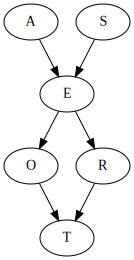

In [ ]:
# deafult layout engine = 'dot'
g = gr.Digraph()
g.edges(model.edges())
g

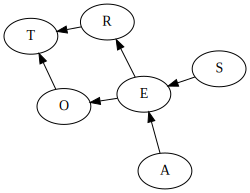

In [ ]:
# layout engine = neato
g = gr.Digraph(engine='neato')
g.edges(model.edges())
g

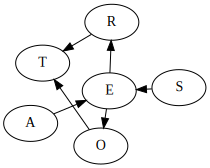

In [ ]:
# layout engine = fdp
g = gr.Digraph(engine='fdp')
g.edges(model.edges())
g